## This script evaluate data from two testing patients. This will test the data quality of data recorded from Ruijin Hospital based on two paradigms: simplified pinyin and three-class movement.

In [1]:
import copy

from speech_pinyin.config import *
import glob
from scipy.io import wavfile
import matplotlib.pylab as plt
import mne
import numpy as np
from utils.util_MNE import keep_annotation
import itertools

pre_all: Running from CMD.
common_dl.py: Using CUDA.


In [2]:
sid=3
folder=data_dir+str(sid)+'-*'
folder=os.path.normpath(glob.glob(folder)[0])
folder=folder.replace("\\", "/")


In [3]:
# Read EEG
file=glob.glob(os.path.join(folder,'raw','*.edf'))[0]
raw = mne.io.read_raw_edf(file,preload=True)
raw.resample(sfreq=1000)

<RawEDF | 20240913{FEE6ACE5-B5B6-450E-9FF2-B7BDB03D05C6} Data.edf, 132 x 1509000 (1509.0 s), ~1.48 GB, data loaded>

In [4]:
# Read audio
session=1
audio_folder=folder+'/raw/matlab/result/pinyin_simplified/'
files=['JinKeFen_202409131117']
file=audio_folder+files[session-1]+'/recording.wav'
sf_audio,audio=wavfile.read(file)

C:\Users\xiaowu\AppData\Local\Temp\ipykernel_20780\1434335518.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf_audio,audio=wavfile.read(file)


In [5]:
import hdf5storage
filename=folder+'/raw/matlab/result/pinyin_simplified/JinKeFen_202409131117/prompt_shown.mat'
mat=hdf5storage.loadmat(filename)
prompt_shown=mat['prompt_shown'][0]

filename=folder+'/raw/matlab/result/movement/name_202409131128/prompt_shown.mat'
mat=hdf5storage.loadmat(filename)
prompt_shown_movement=mat['prompt_shown'][0]


In [6]:
classes=[]
for i in range(len(prompt_shown)):
    tmp1=prompt_shown[i][0].split("@")
    prompt=tmp1[1]
    time=datetime.strptime(tmp1[0],'%Y-%m-%d %H:%M:%S:%f')
    if prompt=='a':
        classes.append(1)
    elif prompt=='e':
        classes.append(2)
    elif prompt=='i':
        classes.append(3)    
    elif prompt=='u':
        classes.append(4)
    elif prompt=='':
        classes.append(99)


classes_movement=[] # 18 trials
for i in range(len(prompt_shown_movement)):
    tmp1=prompt_shown_movement[i][0].split("@")
    prompt=tmp1[1][-1]
    time=datetime.strptime(tmp1[0],'%Y-%m-%d %H:%M:%S:%f')
    if prompt==chr(0x01):
        classes_movement.append(1)
    elif prompt==chr(0x02):
        classes_movement.append(2)
    elif prompt==chr(0x03):
        classes_movement.append(3)    
    elif prompt=='':
        classes_movement.append(99)

print(len(classes))
print(len(classes_movement))

66
18


In [112]:
# pinyin simplified recordings
trial_begins=[]
beep=[1,0,1,0,1,0]
index=0
while index<len(audio)-10:
    if all(audio[index:index+6]==beep):
        trial_begins.append(index+6)
        index=index+5*48000 # jump before step-by-step search
    index=index+1
print(len(trial_begins))

65


In [8]:
# remove the beep
audio_clean=[]
lengths=[]
for i in range(len(trial_begins)):
    if i==len(trial_begins)-1:
        trial_start=trial_begins[i]
        tmp=audio[trial_start:]
    else:
        trial_start=trial_begins[i]
        trial_stop=trial_begins[i+1]-6
        tmp=audio[trial_start:trial_stop]
    length=len(tmp)
    lengths.append(length/48000)
    audio_clean.append(tmp)
print(len(audio_clean))

66


In [9]:
audio2=[sample for sublist in audio_clean for sample in sublist]
len(audio2)/48000

343.26

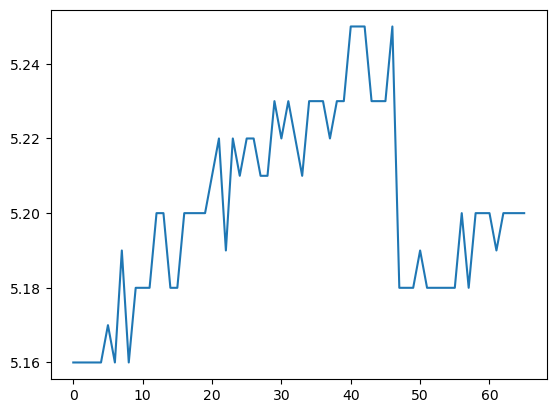

In [10]:
# save trial length
plt.plot(lengths)
filename=folder+'/processed/session'+str(session)+'_trial_length_audio'
#np.save(filename, np.array(lengths, dtype=object), allow_pickle=True)

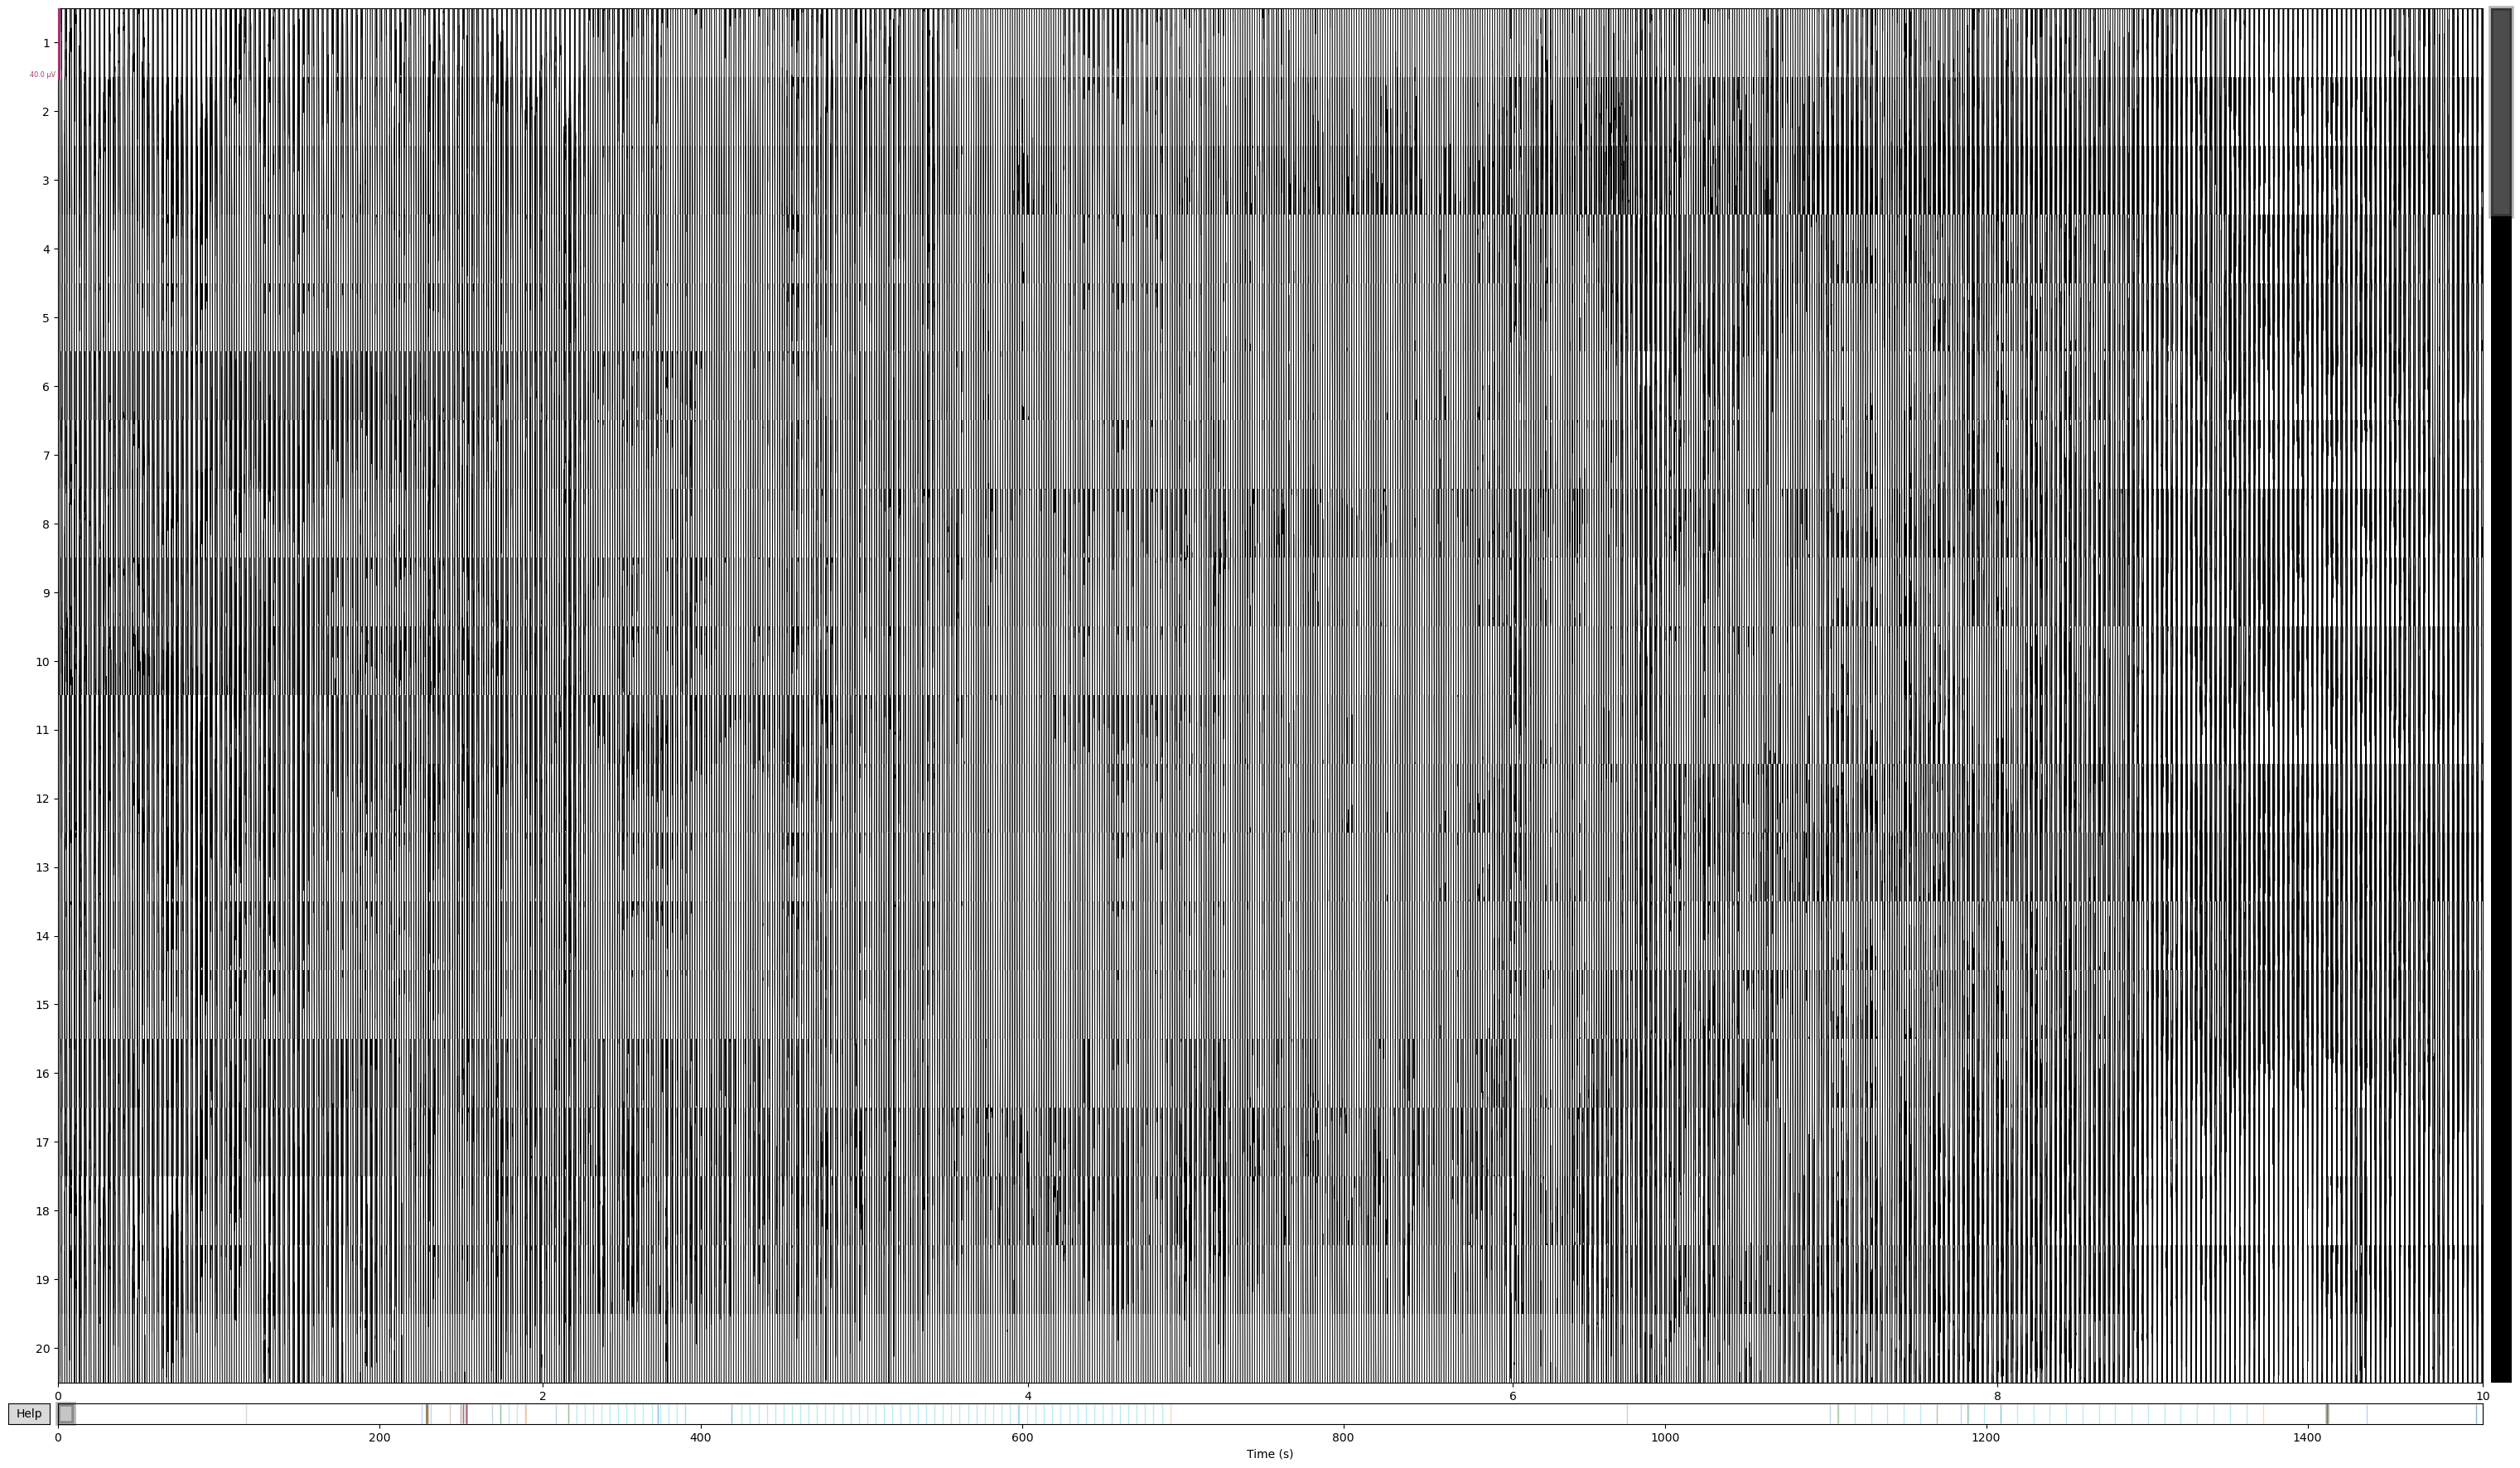

In [15]:
%matplotlib qt
raw.plot()

In [8]:
raw_pinyin=raw.copy().crop(tmin=305 ,tmax=695)
raw_movement=raw.copy().crop(tmin=1182 ,tmax=1375)

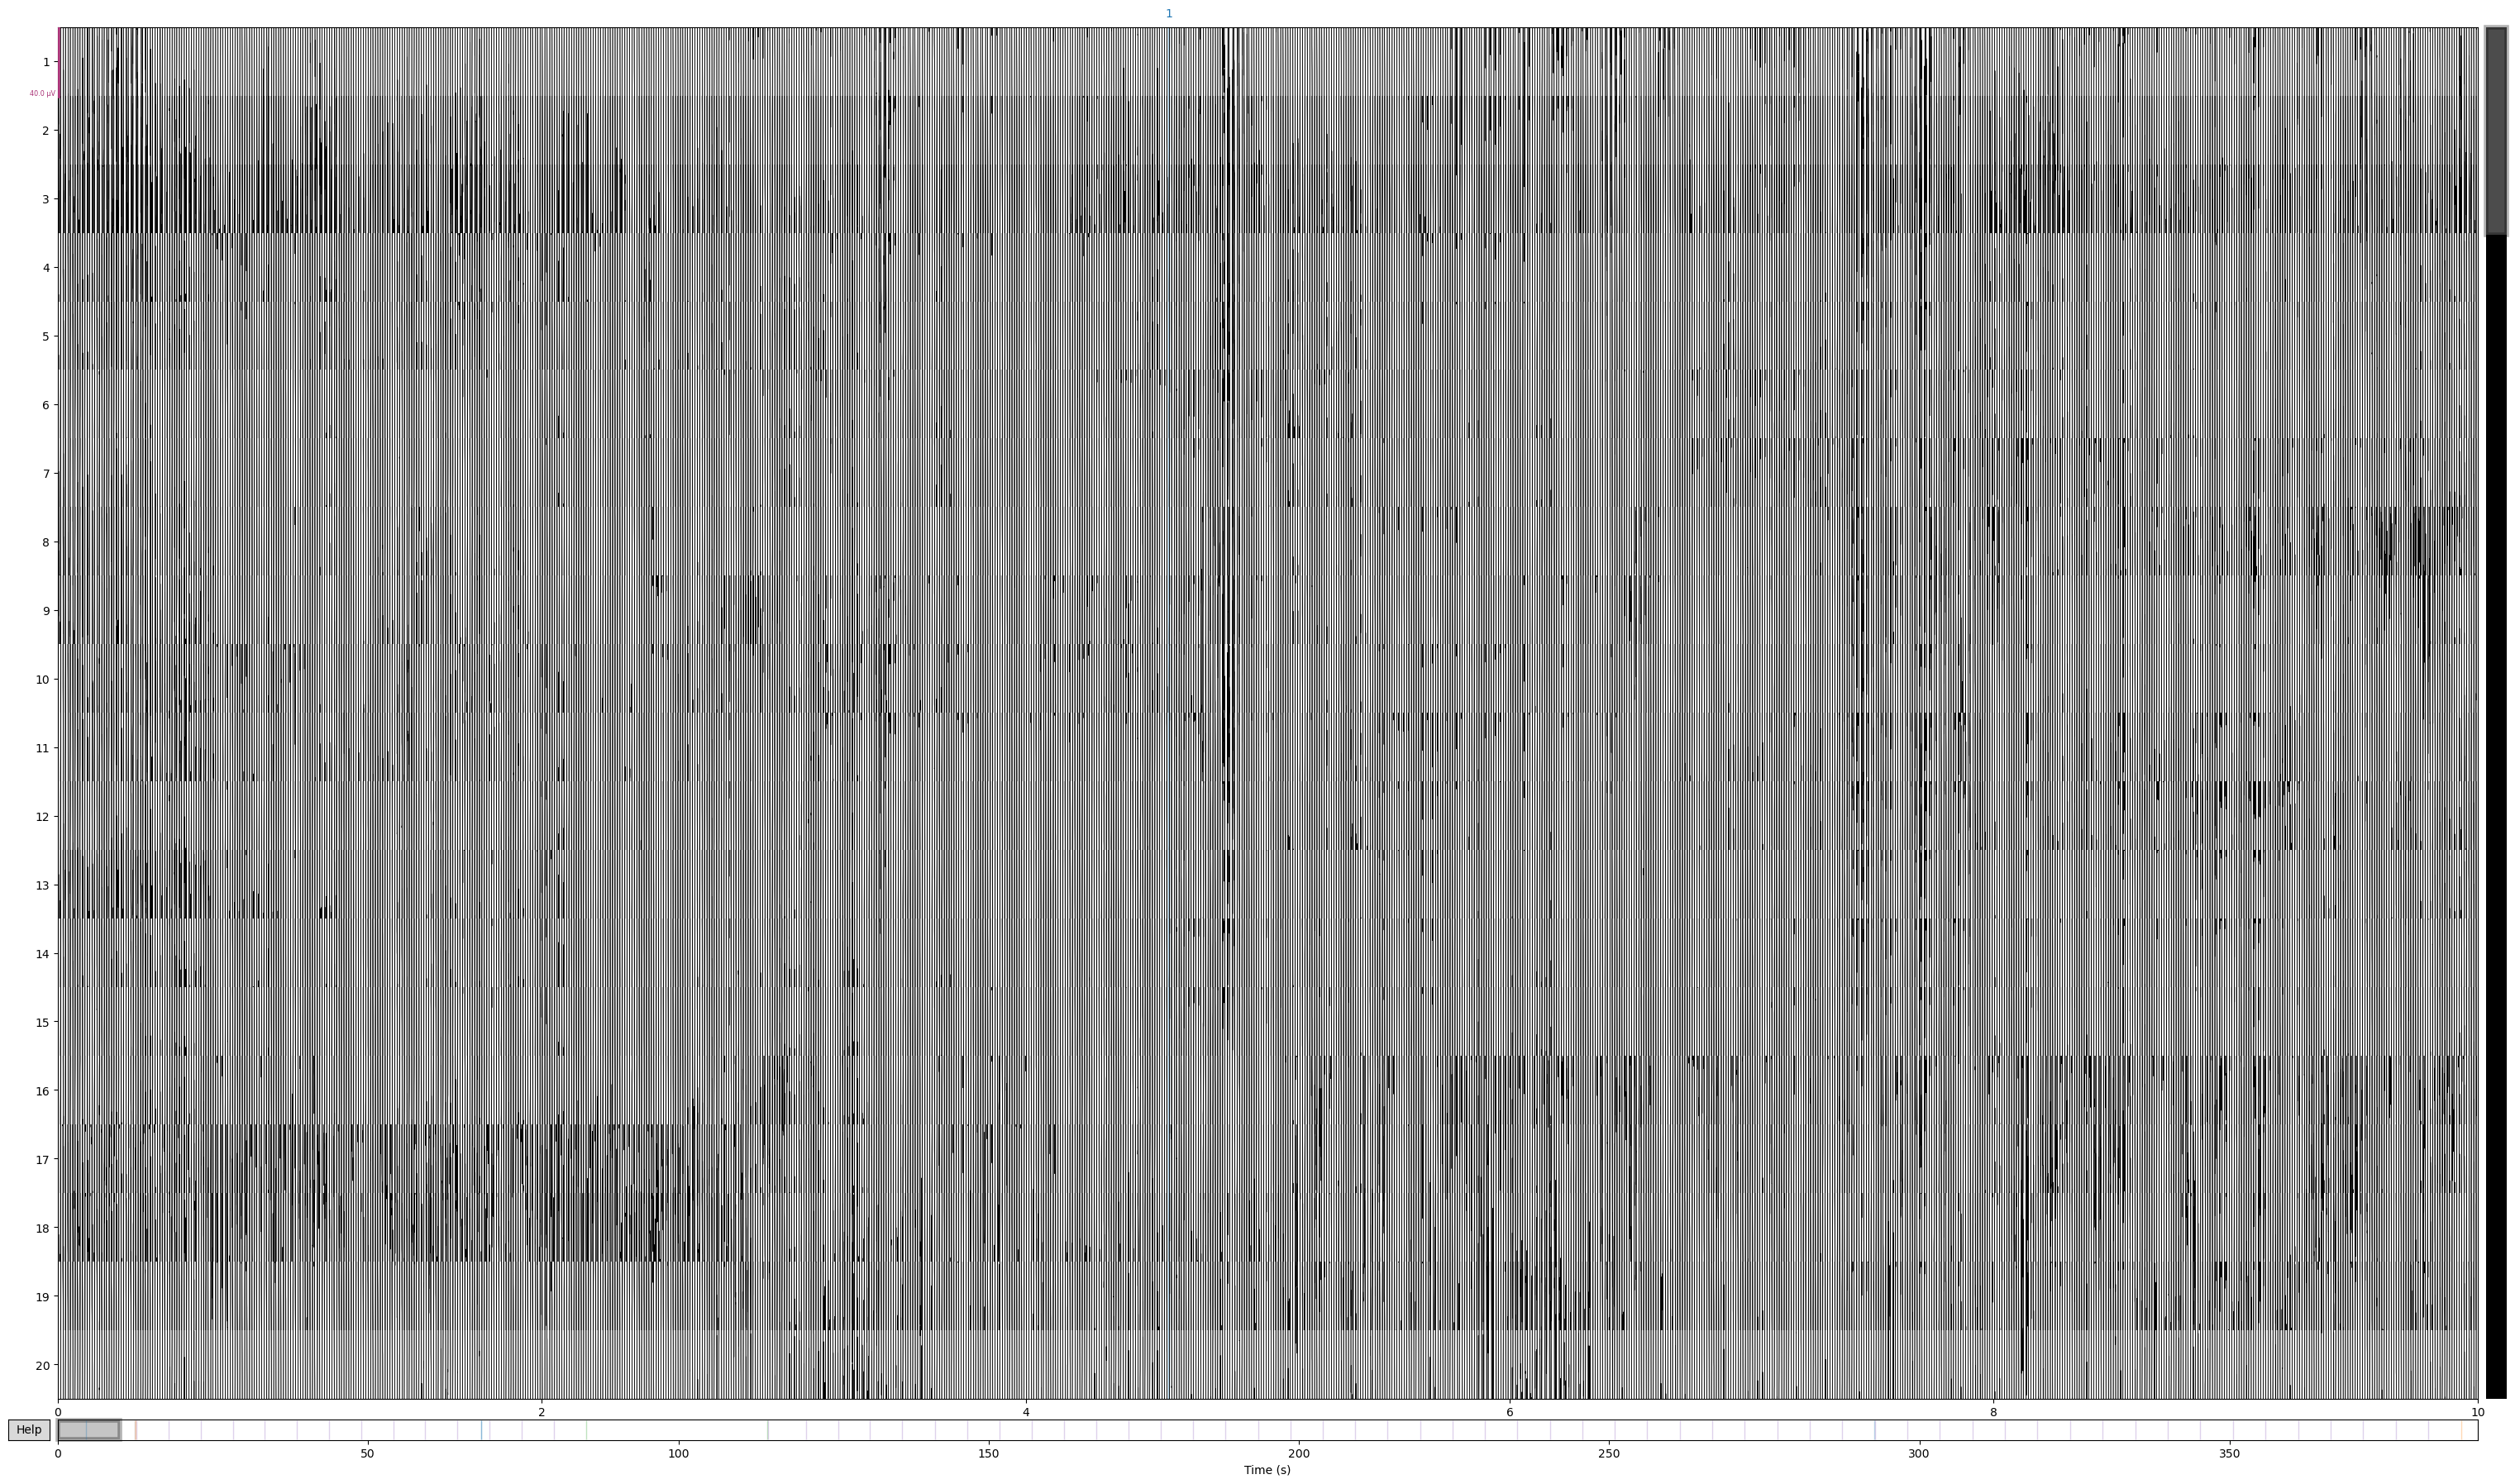

In [46]:
%matplotlib qt
raw_pinyin.plot()

In [9]:
events_tmp=mne.find_events(raw_pinyin, stim_channel='Trigger')
events_movement_tmp=mne.find_events(raw_movement, stim_channel='Trigger')

In [115]:
# 91---92---93---5---5--5--94--94--5---5---5---93
import copy
events_tmp2=copy.deepcopy(events_tmp)
for i in range(events_tmp.shape[0]):
    if events_tmp[i,-1]==82127:
        events_tmp2[i,-1]=91
    elif events_tmp[i,-1]==110417:
        events_tmp2[i,-1]=92
    elif events_tmp[i,-1]==118433:
        events_tmp2[i,-1]=93
    elif events_tmp[i,-1]==98158:
        events_tmp2[i,-1]=5
    elif events_tmp[i,-1]==86135:
        events_tmp2[i,-1]=94 # pause

events_movement_tmp2=copy.deepcopy(events_movement_tmp)
for i in range(events_movement_tmp.shape[0]):
    if events_movement_tmp[i,-1]==82127:
        events_movement_tmp2[i,-1]=91
    elif events_movement_tmp[i,-1]==110417:
        events_movement_tmp2[i,-1]=92
    elif events_movement_tmp[i,-1]==118433:
        events_movement_tmp2[i,-1]=93
    elif events_movement_tmp[i,-1]==98158:
        events_movement_tmp2[i,-1]=5
    elif events_movement_tmp[i,-1]==86135:
        events_movement_tmp2[i,-1]=94 # pause

events=copy.deepcopy(events_tmp2)
j=0
for i in range(events_tmp2.shape[0]):
    if events_tmp2[i,-1]==5:
        events[i,-1]=classes[j]
        j=j+1
print(str(j))
events_movement=copy.deepcopy(events_movement_tmp2)
j=0
for i in range(events_movement_tmp2.shape[0]):
    if events_movement_tmp2[i,-1]==5:
        events_movement[i,-1]=classes_movement[j]
        j=j+1
print(str(j))
# extract task event ('5')
events_tasks=np.asarray([event for event in events if event[-1] not in [91,92,93,94,99]])
events_tasks_movement=np.asarray([event for event in events_movement if event[-1] not in [91,92,93,94,99]])


66
18


In [17]:
raw_pinyin.add_events(events_tasks, "Trigger",replace=True)
raw_movement.add_events(events_tasks_movement, "Trigger",replace=True)

In [44]:
intervals=[]
for i in range(len(events_tasks)-1):
    start=events_tasks[i,0]
    end=events_tasks[i+1,0]
    tmp=(end-start)/1000
    intervals.append(tmp)

In [45]:
%matplotlib inline
#plt.plot(lengths)
#plt.plot(intervals)
difference=[i-j for i,j in zip(lengths, intervals)]
accum=np.cumsum(difference)
plt.plot(difference)
plt.plot(accum)

NameError: name 'lengths' is not defined

In [18]:
raw_pinyin.drop_channels(['113','114','ECG','EMG','EXG']) # 113/114 are reference and ground
raw_pinyin.drop_channels(['36','71','72']) # re-wire these three channels to 121, 122,123
raw_pinyin.drop_channels([str(i) for i in range(124,129)]) # 121-128 is not seeg channels according to 2.jpeg and psd plot.

raw_movement.drop_channels(['113','114','ECG','EMG','EXG'])
raw_movement.drop_channels(['36','71','72'])
raw_movement.drop_channels([str(i) for i in range(124,129)])

<RawEDF | 20240913{FEE6ACE5-B5B6-450E-9FF2-B7BDB03D05C6} Data.edf, 119 x 193001 (193.0 s), ~175.3 MB, data loaded>

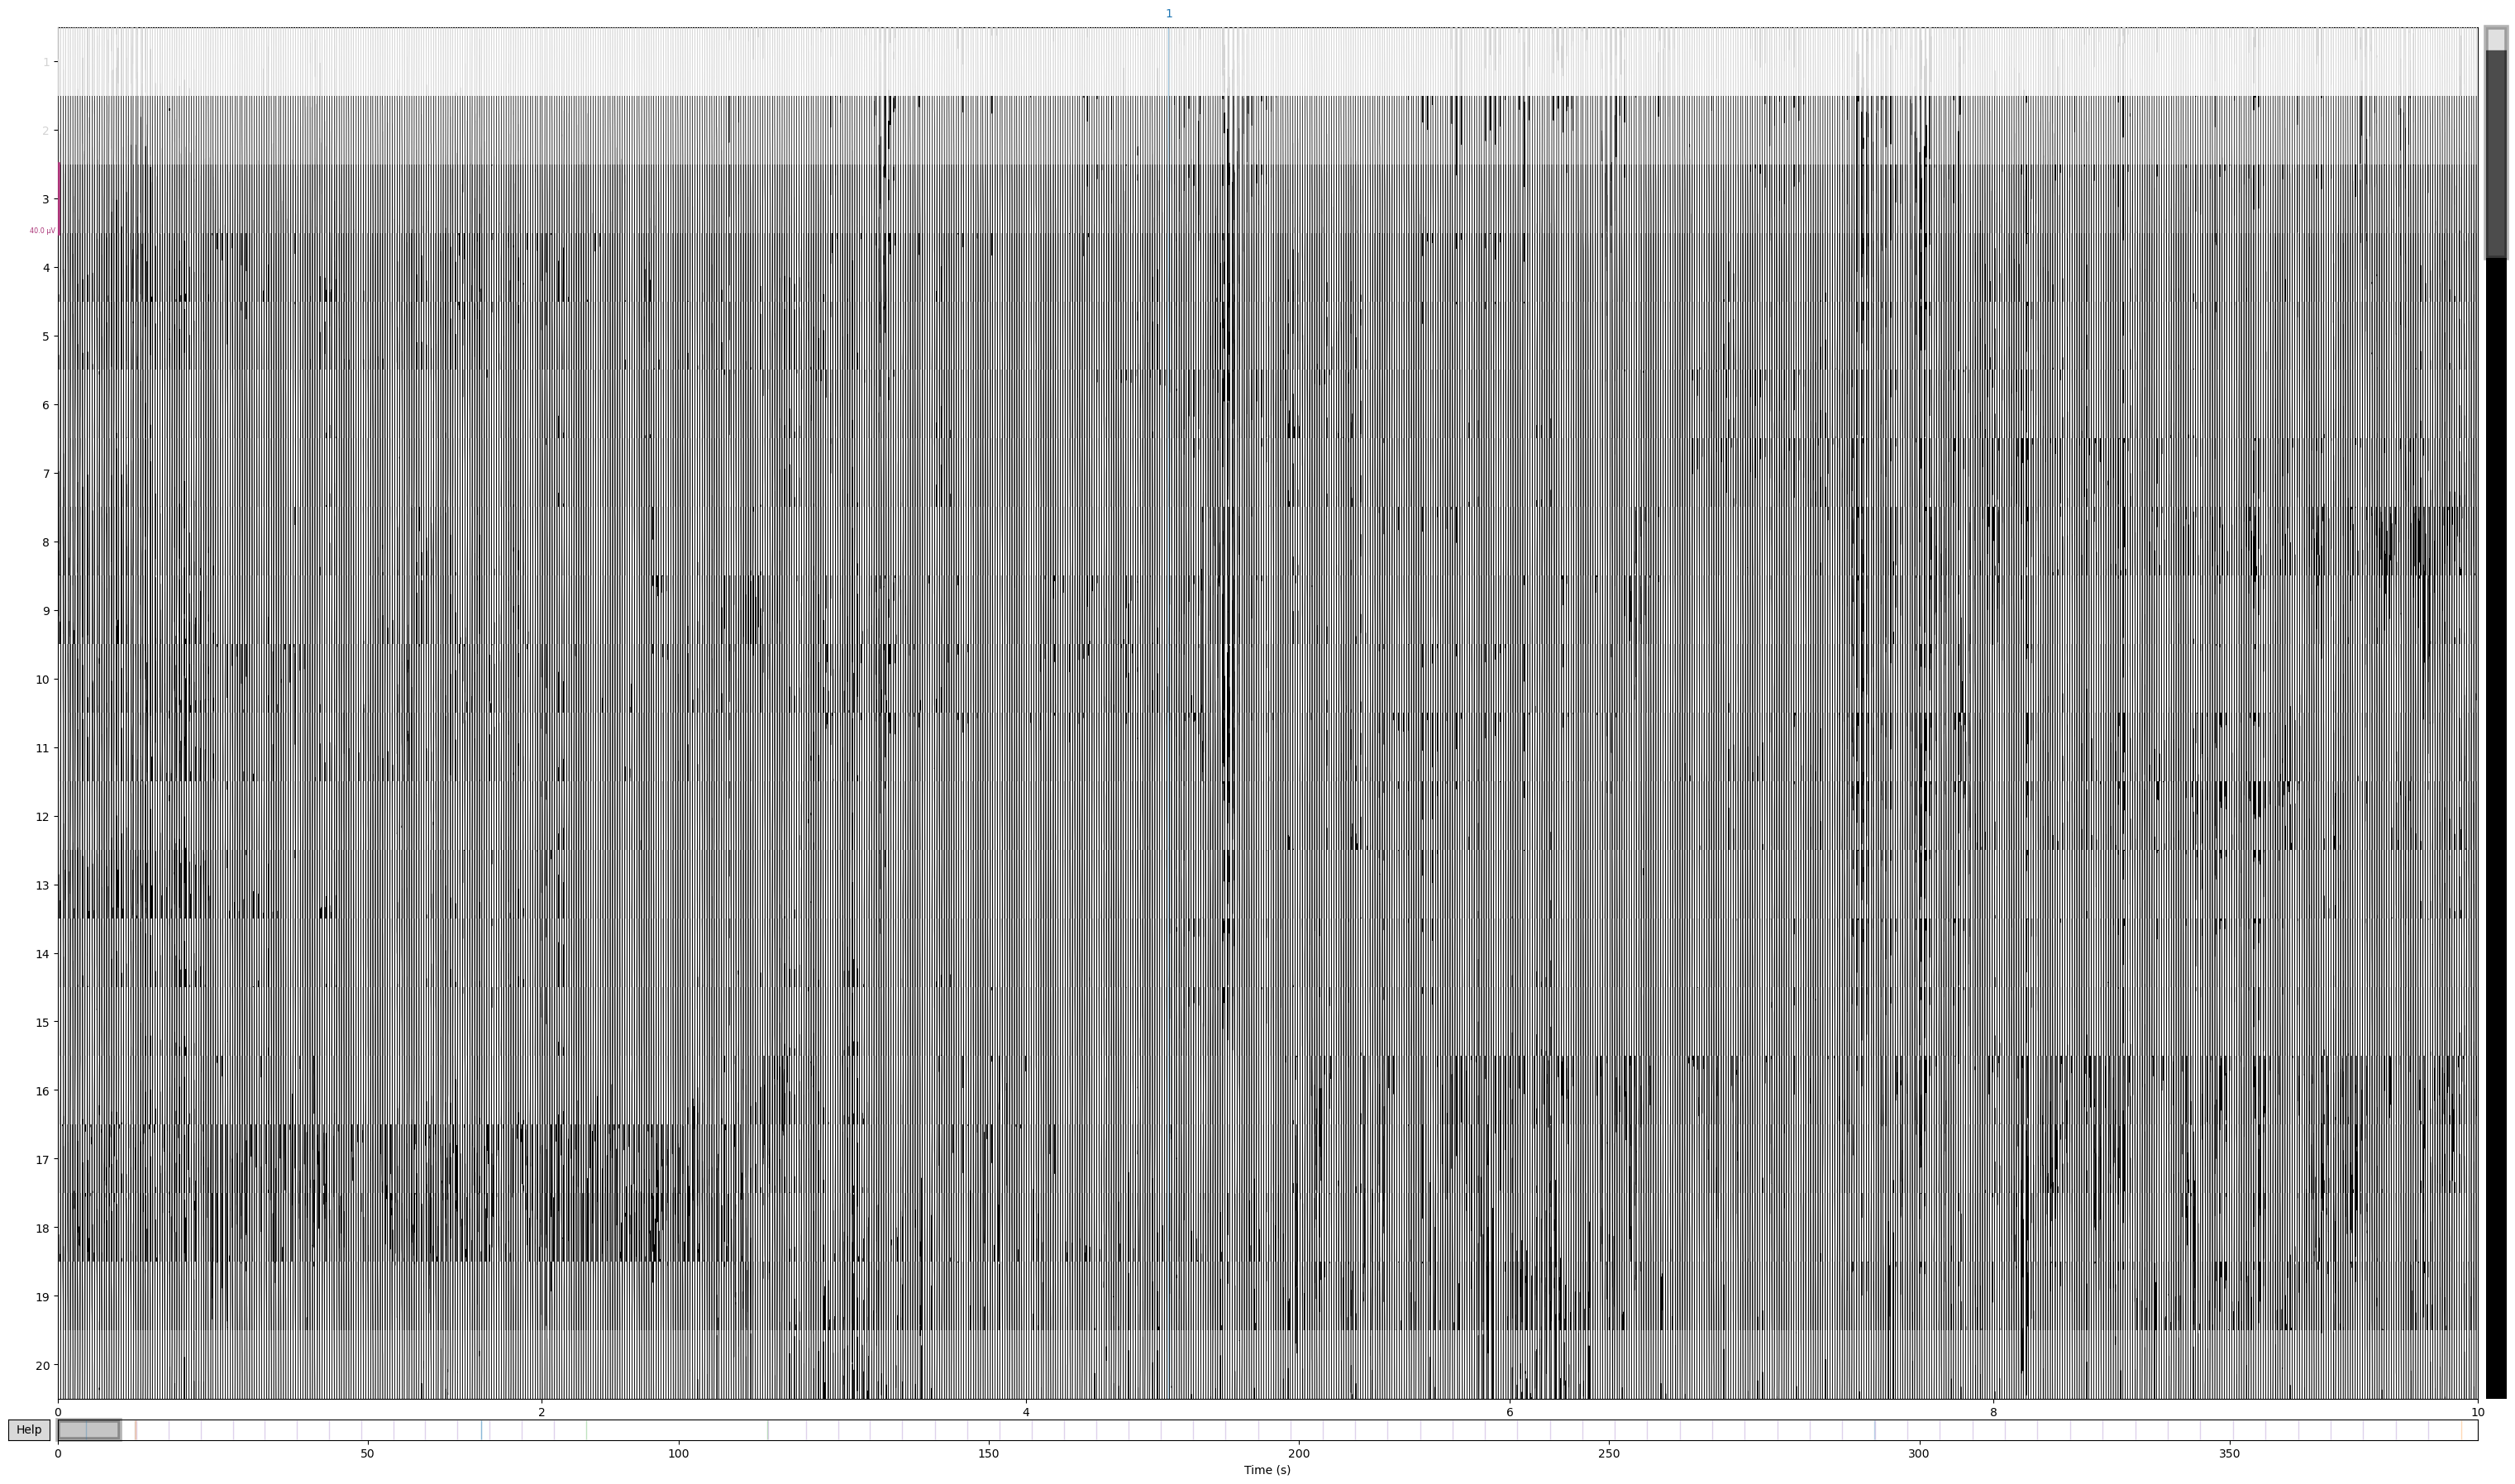

In [57]:
%matplotlib qt
raw_pinyin.plot()

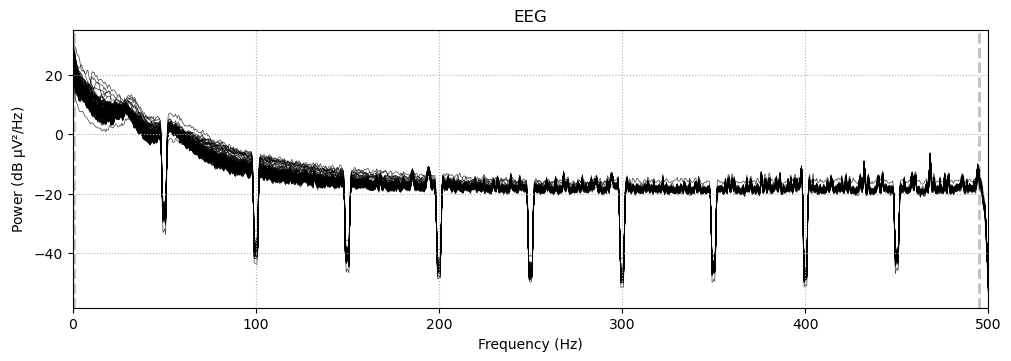

In [120]:
%matplotlib qt
raw_movement.compute_psd().plot()

In [19]:
raw_pinyin.filter(0.5,495)
frequency=np.arange(50, 500, 50).tolist()
notch_widths=np.asarray([3,]*len(frequency))
raw_pinyin.notch_filter(freqs=frequency,notch_widths=notch_widths)


raw_movement.filter(0.5,495)
frequency=np.arange(50, 500, 50).tolist()
notch_widths=np.asarray([3,]*len(frequency))
raw_movement.notch_filter(freqs=frequency,notch_widths=notch_widths)

<RawEDF | 20240913{FEE6ACE5-B5B6-450E-9FF2-B7BDB03D05C6} Data.edf, 119 x 193001 (193.0 s), ~175.3 MB, data loaded>

In [20]:
filename=folder+'/processed/pinyin.fif'
raw_pinyin.save(filename,overwrite=True)

filename=folder+'/processed/movement.fif'
raw_movement.save(filename,overwrite=True)

In [8]:
test_on='pinyin'

if test_on=='pinyin':
    raw_pinyin=mne.io.read_raw_fif('D:/data/BaiduSyncdisk/speech_pinyin/3-135/processed/pinyin.fif')
    events=mne.find_events(raw_pinyin, stim_channel='Trigger')
    epochs_all = mne.Epochs(raw_pinyin, events, tmin=0, tmax=5,baseline=None)
    
    task_id=1 # 1/2/3/4
    #epochs=epochs_all[str(task_id)]
    epochs=epochs_all
elif test_on=='movement':
    raw_movement=mne.io.read_raw_fif('D:/data/BaiduSyncdisk/speech_pinyin/3-135/processed/movement.fif')
    events=mne.find_events(raw_movement, stim_channel='Trigger')
    epochs_all = mne.Epochs(raw_movement, events, tmin=0, tmax=10,baseline=None)
    
    task_id=1
    #epochs=epochs_all[str(task_id)]
    epochs=epochs_all

In [9]:
decim=4
new_fs=1000/decim
n_cycles_mthod='stage' # or: equal
vmin=-4
vmax=4
fMin,fMax=2,150
fstep=1
freqs=np.arange(fMin,fMax,fstep) #148
fNum=freqs.shape[0]
#freqs = np.linspace(fMin,fMax, num=fNum)
cycleMin,cycleMax=8,50
cycleNum=fNum
#n_cycles = np.linspace(cycleMin,cycleMax, num=cycleNum)  # different number of cycle per frequency
groups=5
rates=[2,2.5,3,4,5]
num_per_group=int(fNum/groups)
if n_cycles_mthod=='equal':
    n_cycles=freqs
elif n_cycles_mthod=='stage':
    n_cycles=[]
    for g in range(groups):
        if g < groups -1:
            tmp=[int(i) for i in freqs[g*num_per_group:(g+1)*num_per_group]/rates[g]]
        elif g==groups -1:
            tmp = [int(i) for i in freqs[g * num_per_group:] / rates[g]]
        n_cycles.extend(tmp)

In [10]:
# better than the above MNE method.
%matplotlib inline
from mne.time_frequency import tfr_morlet
if test_on=='pinyin':
    baseline = [int(0*new_fs), int(3*new_fs)]
elif test_on=='movement':
    baseline = [int(0*new_fs), int(5*new_fs)]
ch_names=epochs.ch_names
chnNum=len(ch_names)
chid=0
for chid in range(chnNum-1):
    fig,ax=plt.subplots()
    chname=epochs.ch_names[chid]
    # The very big artifact at begainning and end of the TF will cause ERS vanish after normalization.
    ch_power=np.squeeze(tfr_morlet(epochs, picks=[chname], freqs=freqs, n_cycles=n_cycles,use_fft=True,return_itc=False, 
                                   average=True, decim=decim, n_jobs=1).data) # (148, 1251) (frequency, time)

    base = ch_power[:, baseline[0]:baseline[1]] #  (148, 175)
    basemean = np.mean(base, 1) # (148)
    basestd= np.std(base, 1) #(148) 
    #ch_power_norm = 10*np.log10(ch_power / basemean[:, :, None]) #
    ch_power_norm=(ch_power-basemean[:,None])/basestd[:,None]
    ax.imshow(ch_power_norm,origin='lower', cmap='RdBu_r',vmin=vmin, vmax=vmax) # same as below
    ax.set_aspect('auto')
    if test_on=='pinyin':
        filename=folder+'/processed/tf_result_pinyin/ch_'+str(chid)+'.png'
    elif test_on=='movement':
        filename=folder+'/processed/tf_result_movement/ch_'+str(chid)+'.png'
    fig.savefig(filename, dpi=400)
    fig.clear()
    plt.close(fig)

The best plot:

![](img\16.png)